# College Basketball Analytics
Darren Lund  
ACME

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

## Introduction  

The art of predicting the outcome of a competition is at least as old as the ancient Roman Empire. Just as contests and competitions of skill have intrigued humankind, people have wanted to determine beforehand who the victor would be.  One of the biggest instances of this in our day and age is the NCAA March Madness (Men's College Basketball) Tournament.  A total of 68 teams coming together in a single elimination tournament to determine which college team would come out on top...and millions of fans predicting who will win each game.  This project seeks to do just that; use the seasonal data of each participating team to try and determine their success in this tournament.  

Usually, an endeavor like this takes the form of a page-rank algorithm.  Each team is ranked by the algorithm with the higher ranked team coming out on top in any contest.  While vastly effective, it can miss certain nuances of the game and can miss potential upsets.  The approach presented here seeks to understand those occurances and predict them better by taking two teams and obseving the individual contributions of each player to the game.  It takes the seasonal statistics of each player to try and understand the inner workings of the team: who contributed most to points scored close to the basket, who contributed most to their outside shooting, who holds the defense together, and, most importantly, what each of these contributions have on the final score.  

To answer these questions, data was scraped directly from https://kenpom.com/, a website maintained by Ken Pomeroy, a basketball statistician who readily gave permission to use the data he has collected for this project.  As such the data obtained has no reason to be skewed in any way, and should be representative of the actual numbers from the games played.  For each year from 2013 to 2017, and for every team that participated in that year's tournament, a team scouting report has been collected from that year, as well as a table for each player on the team that includes that players' statistics for each game that season.

## Data Gathering and Cleaning

While the full code used for gathering and cleaning the data is given separately, a brief overview is presented here.  The first step was getting the information off of Ken's website.  This was accomplished using Selenium, and crawling through his site (year by year, team by team, and player by player), opening all needed webpages, then parsing the html through BeautifulSoup to get the desired tables.  After saving these in html format, they were reloaded so they could be converted to csv files.  The reason for doing this separately was mostly to save time when developing the code.  This way the lengthy process of downloading the information could be achieved without any data corruption, and all processing of the data could come after (and thus any mistakes that would inadvertently delete the desired information wouldn't require a few more hours to redownload it).  After converting all data to csv files, they were then loaded into pandas dataframes and cleaned.  

The main part of the scouting report that needed cleaning was removing the "rankings" of statistics from the statistics themselves, as well as removing superfluous symbols (such as a + symbol, or % sign).  However, there were a number of statistics that were the same for two columns, so Ken put that number in the first column, displayed it in the middle of the table, and then put the data for the next column in the place where the second column would be, so that placing needed to be corrected.  For the defensive fingerprint row (which is just a string), the contents were placed in each column so that no matter what column was observed, you could obtain the information.  The final thing that had to be done was name the columns appropriately, and save the cleaned dataframe as a separate file (the reason for another file is so that any errors could be quickly and easily corrected from the original, without needing to redownload).
The player data cleaning was a bit simpler.  After removing extra html code from table, columns were named as needed, and extra columns dropped, so that only the player statistics and specific game information remained.  Game information includes: the date the game was played; what team they played; the final score; number of over-times; whether the game was played on a "home" court, an "away" court, or a "neurtral" court; and whether or not it was a conference or tournament game.  Player statistics include: minutes played; offensive rating; percentage of possessions used; points; two-pointers, made and attempted; three-pointers, made and attempted; free-throws, made and attempted; number of offensive rebounds; number of defensive rebounds; assists; turn overs; blocks; steals; and personal fouls.  If a player did not play a certain game, these statistics were all set to zero.  Likewise, if the data had a hyphen instead of a zero, it was set to zero.  There were also eight players (DaMetrius Upchurch of NCA&T, 2013; Geoff Groselle of Creighton, 2014; Evan Wesenberg of North Dakota St., 2015; Tom Wamukota of Wichita St., 2015; Brian Greene of Florida Gulf Coast, 2016; Levan (Shizz) Alston of Temple, 2016; Ty Taylor of Wichita St., 2016; and Larry Austin of Xavier, 2016) who had two rows of statistics for a specific game, which I removed manually.  

Certain statistics were then included for each game to better understand each player's personal contribution to the offense and the defense.  These were: the percentage of two-pointers, three-pointers, and free-throws that each player took for a specific team; the approximate number of points prevented by the player [calculated as 2*((# of blocks) + (# of steals) - (# of turnovers)] (NOTE: this number can be negative if the player gave up more potential points through turnovers than they prevented); and the margin of victory (which was negative if the team lost).  The first set of statistics will serve to represent the player's offensive contribution to the game, the second their defensive contribution, and the last to the overall result of the game.  Below is an example of the final data set for Nigel-Williams-Goss, of Gonzaga, for the year 2017, game against North Carolina, as well as Gonzaga's scouting report.

In [2]:
player = pd.read_csv('./DATA/2017/Gonzaga/Nigel Williams-Goss_adj')
# Everytime you save it adds an extra column of the indices,
#     so remove it
player = player.drop('Unnamed: 0',axis=1)
team = pd.read_csv('./Data/2017/Gonzaga/Scouting_Report_csv')
team = team.drop('Unnamed: 0',axis=1)

In [3]:
print(player.loc[0])

Date                   Apr 3
Opponent      North Carolina
Result              L, 71-65
OTs                      0OT
Site                 Neutral
Conference            NCAA-T
MP                        39
ORtg                      86
%Ps                       28
Pts                       15
2Pt                     4-14
3Pt                      1-3
FT                       4-8
OR                         2
DR                         7
A                          6
TO                         2
Blk                        0
Stl                        0
PF                         3
2Pt %Att                0.35
3Pt %Att            0.157895
FT %Att             0.307692
Pnts-Prev                 -4
Marg                      -6
Name: 0, dtype: object


In [4]:
print(team)

                  Category     Offense     Defense    D-I Avg.
0          Adj. Efficiency       118.4        86.3       104.7
1               Adj. Tempo        70.1        70.1        68.1
2        Avg. Poss. Length        15.9        18.1        17.3
3           Effective FG%:        56.6        41.1        50.5
4              Turnover %:        16.2        17.1        18.5
5             Off. Reb. %:        30.0        26.2        29.3
6                 FTA/FGA:        39.0        26.9        35.3
7                     3P%:        38.2        29.0        35.0
8                     2P%:        56.3        40.0        49.3
9                     FT%:        71.7        65.8        70.4
10                 Block%:         7.8        11.2         9.2
11                 Steal%:         7.6         9.6         8.7
12                3PA/FGA:        32.8        32.1        36.4
13                  A/FGM:        51.8        43.2        52.4
14  Defensive Fingerprint:  Mostly Man  Mostly Man  Mos

## Analysis

For purposes of this project and analysis, analysis will be done on the championship game in 2017 between Gonzaga and North Carolina.  
The first step is to determine which players from each team will end up contributin the most to this game.  Since it's a tournament game, it's highly unlikely that everyone will play, unless the game is so far gone that the winner is already determined.  Since this is the final game, it makes sense that only the best players of each team would be present, both in offense and defense.  For offense, priority is given to those who consistently attempt the most shots.  Why look only at attempts, as opposed to whoever scores the most?  Well, as basketball is a team sport, the team tends to give the ball to those who shoot best.  While anyone can have an on or off day (thus maybe having a poor shooter with a relatively high number of shots made, or a good shooter with a relatively low number), the team will consistently give opportunities to the players they trust to shoot the ball.  Not only that, but the more shot attempts a player has, the longer they likely have played in the game, and so the more likely it is that the coach trusts them to push the team to victory.  Finally, the more times you try something the greater probability you have of succeeding at it, so those who shoot the ball more are probably those who contribute most to the final score.  
Below is code and the graph for the number of attempted two-point shots.  
NOTE: The first row (0) is dropped because that IS the Gonzaga North Carolina game.  It makes no sense to do this analysis while including the statistics of a game that, from the analysts' point of view, hasn't actually happened yet.

In [5]:
NC = {}
Gz = {}
path = './DATA/2017/'
for dir_path , dir_name , file_names in os.walk(path+'North Carolina') :
    for name in file_names :
        if name[-3:] == 'adj' :
            player_name = name[:-4]
            NC[player_name] = pd.read_csv(os.path.join(dir_path,name))
            NC[player_name] = NC[player_name].drop('Unnamed: 0',axis=1)
            NC[player_name] = NC[player_name].drop(0)
for dir_path , dir_name , file_names in os.walk(path+'Gonzaga') :
    for name in file_names :
        if name[-3:] == 'adj' :
            player_name = name[:-4]
            Gz[player_name] = pd.read_csv(os.path.join(dir_path,name))
            Gz[player_name] = Gz[player_name].drop('Unnamed: 0',axis=1)
            Gz[player_name] = Gz[player_name].drop(0)

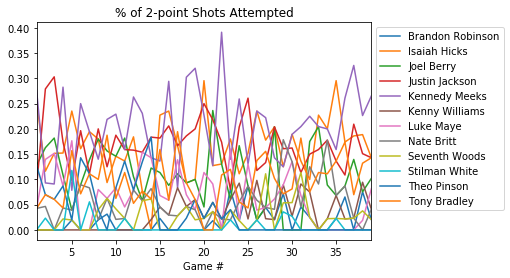

In [6]:
NC_two_atts_all = [NC[player]['2Pt %Att'] for player in NC.keys()]
NC_two_pointers = np.array(NC_two_atts_all).T
NC_twos = pd.DataFrame(NC_two_pointers, 
                       index=NC[list(NC.keys())[0]].index, 
                       columns=NC.keys())
NC_twos.plot()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.title('% of 2-point Shots Attempted')
plt.xlabel('Game #')
plt.show()

Now the clever analyst will note that this graph is a jumbled up mess.  However, it allows us to identify those who consistently attempt a fair percentage of the team's two-point shots, and filter out the rest.  In this case, it appears that Kennedy Meeks, Isaiah Hicks, Justin Jackson, Joel Berry, and Tony Bradley are among these shooters.

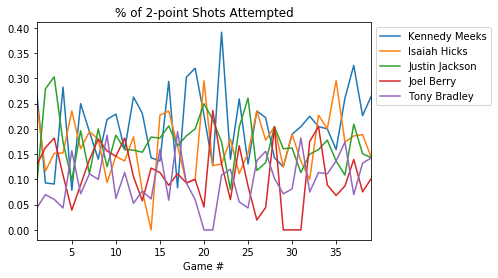

In [7]:
top_shooters = ['Kennedy Meeks',
                'Isaiah Hicks',
                'Justin Jackson',
                'Joel Berry',
                'Tony Bradley']
NC_two_atts = [NC[player]['2Pt %Att'] for player in top_shooters]
NC_two_points = np.array(NC_two_atts).T
NC_twos = pd.DataFrame(NC_two_points, 
                       index=NC[list(NC.keys())[0]].index, 
                       columns=top_shooters)
NC_twos.plot()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.title('% of 2-point Shots Attempted')
plt.xlabel('Game #')
plt.show()

Similar plots are then created for three-point shots, free-throws, and finally (for defense) points prevented.  Since these graphs are as messy as the one shown, they are excluded from this presentation, but are included in the Analysis and Graphing file.  
Each player is then assigned a point for each list to which they pertain.  Those with the highest scores should be those who are the top overall performers, with the cut-off being either eight players, or no one else scoring at least a two (whichever comes first).  In this case, for North Caronlina, that list is (in order from highest scoring to lowest) Justin Jackson, Isaiah Hicks, Joel Berry, Kennedy Meeks, Luke Maye, and Nate Britt.  For Gonzaga, a similar analysis gives Johnathan Williams, Nigel Williams-Goss, Jordan Mathews, Przemek Karnowski, Zach Collins, and Silas Melson.  In almost all cases, this lines up with the top contributers and role players that Ken has included on his site.

In [8]:
NC_top_players = ['Isaiah Hicks',
                  'Joel Berry',
                  'Justin Jackson',
                  'Kennedy Meeks',
                  'Luke Maye',
                  'Nate Britt']
Gz_top_players = ['Johnathan Williams',
                  'Jordan Mathews',
                  'Nigel Williams-Goss',
                  'Przemek Karnowski',
                  'Zach Collins',
                  'Silas Melson']
NC_top = {key:value for key,value in NC.items() if key in NC_top_players}
Gz_top = {key:value for key,value in Gz.items() if key in Gz_top_players}

Now, for each of these players it's important to get their average statistics.  This way, once it's been determined approximately how many shots each team will get (from team statistics in the scouting report), they can be proportioned appropriately among the players most likely to take those shots, along with how likely they are to make them.

In [9]:
NC_avgs = {}
NC_data = []
for player in NC_top.keys() :
    data = NC_top[player]
    n = len(data.index)
    two_pt_att_avg = sum(data['2Pt %Att'])/n
    three_pt_att_avg = sum(data['3Pt %Att'])/n
    ft_tp_att_avg = sum(data['FT %Att'])/n
    points_avg = sum(data['Pts'])/n
    pnts_prev_avg = sum(data['Pnts-Prev'])/n
    NC_avgs[player] = [two_pt_att_avg,
                       three_pt_att_avg,
                       ft_tp_att_avg,
                       points_avg,pnts_prev_avg]
    if isinstance(NC_data,list) :
        NC_data = np.array(NC_avgs[player])
    else :
        NC_data = np.vstack((NC_data,NC_avgs[player]))
Gz_avgs = {}
Gz_data = []
for player in Gz_top.keys() :
    data = Gz_top[player]
    n = len(data.index)
    two_pt_att_avg = sum(data['2Pt %Att'])/n
    three_pt_att_avg = sum(data['3Pt %Att'])/n
    ft_tp_att_avg = sum(data['FT %Att'])/n
    points_avg = sum(data['Pts'])/n
    pnts_prev_avg = sum(data['Pnts-Prev'])/n
    Gz_avgs[player] = [two_pt_att_avg,
                       three_pt_att_avg,
                       ft_tp_att_avg,
                       points_avg,pnts_prev_avg]
    if isinstance(Gz_data,list) :
        Gz_data = np.array(Gz_avgs[player])
    else :
        Gz_data = np.vstack((Gz_data,Gz_avgs[player]))

In [10]:
avg_columns = ['2Pt %Att','3Pt %Att','FT %Att','Pts','Pnts-Prev']
NC_avgs_data = pd.DataFrame(NC_data.T,
                            index=avg_columns,
                            columns=NC_avgs.keys())
Gz_avgs_data = pd.DataFrame(Gz_data.T,
                            index=avg_columns,
                            columns=Gz_avgs.keys())

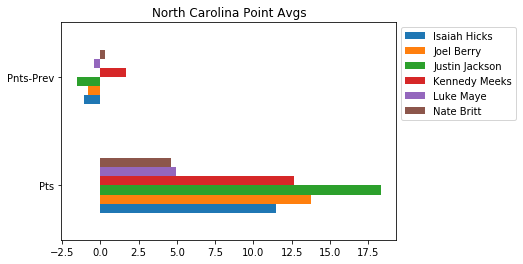

In [11]:
NC_atts_dropped = NC_avgs_data.drop(['FT %Att','3Pt %Att','2Pt %Att'])
NC_atts_dropped.plot(kind='barh',title='North Carolina Point Avgs')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.show()

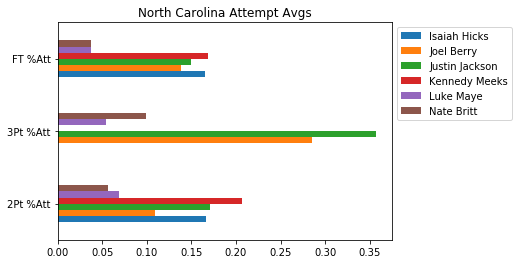

In [12]:
NC_pnts_dropped = NC_avgs_data.drop(['Pnts-Prev','Pts'])
NC_pnts_dropped.plot(kind='barh',title='North Carolina Attempt Avgs')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.show()

These two bar charts indicate something about North Carolina's style of play.  They obvious don't have the best defense, as very few of their main players consistently prevent the opposing team from scoring.  On offense, it would appear that Isaiah will consistently take two-point shots and free-throws, but never attempts a three-point shot.  He's most like one of their centers or forwards, and only plays down low.  Justin Jackson appears to be their primary three-point shooter (helped out by Joel Berry), and Kennedy Meeks seems to to take the most inside shots (probably another center or forward).  Since most of their points seem to come from Justin Jackson and Joel Berry, it would seem like North Carolina prefers to shoot outside, as opposed to taking it inside.  However, they have Kennedy and Isaiah usually score well each game as well, constantly holding up the inside of the court.  Overall, a very balanced approach to their offense.

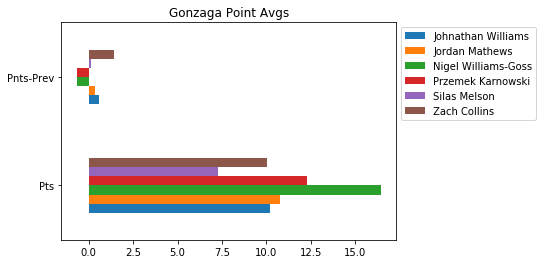

In [13]:
G_atts_dropped = Gz_avgs_data.drop(['FT %Att','3Pt %Att','2Pt %Att'])
G_atts_dropped.plot(kind='barh',title='Gonzaga Point Avgs')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.show()

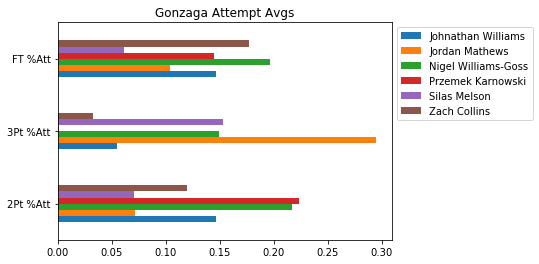

In [14]:
G_pnts_dropped = Gz_avgs_data.drop(['Pnts-Prev','Pts'])
G_pnts_dropped.plot(kind='barh',title='Gonzaga Attempt Avgs')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.show()

Gonzaga appears to be a better defensice team than North Carolina, though they still give up almost as many points as their defense prevents.  As for scoring, Nigel seems to be the star, making most of the teams points from all over the court.  Helping out inside is Przemek Karnowski, who makes up the most of their inside game, together with Nigel's and Johnathan's help.  Their only real outside shooters appear to be Nigel and Jordan, but Jordan doesn't seem to make many of his attempts, as he only averages less than twelve points per game.  As such, their main style of play seems to have Nigel roaming around the court, threatening everywhere, while Przemek posts up inside, with Jordan, Johnathan, and Zach acting as supports. 

At this point, the goal is to use the scouting reports to get the tempo of both teams, and thus predict the average number of possessions each team will have during the game.  With that information and the distribution of how many points they get from three-point shots, two-point shots, and free-throws, the approximate number of points each player will score will be determined, and thus the approximate final score, which would indicate the winner.

In [15]:
NC_scout = pd.read_csv('./DATA/2017/North Carolina/Scouting_Report_csv')
NC_scout = NC_scout.drop('Unnamed: 0',axis=1)
Gz_scout = pd.read_csv('./Data/2017/Gonzaga/Scouting_Report_csv')
Gz_scout = Gz_scout.drop('Unnamed: 0',axis=1)